In [2]:
dpi = 300
image_save_dpi = 300

import matplotlib_inline

%matplotlib inline
%matplotlib inline

import matplotlib.pyplot as plt

matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
%config InlineBackend.figure_formats = ['retina'] 

import seaborn as sns
import matplotlib

sns.set(rc={"figure.dpi":dpi, 'savefig.dpi':dpi})
sns.set_context('notebook')
sns.set_style("ticks")
matplotlib.rcParams["figure.dpi"] = dpi
plt.rcParams['figure.dpi'] = dpi

In [3]:
import numpy as np
import pandas as pd

# Data

In [4]:
data = pd.read_excel('Data/Data_Volcano_Eruption.xlsx',skiprows=[0])
list1 = data[['Volcano Name', 'VEI', 'Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day']]
list1 = list1[
    (list1['Start Year']>=1800)]

## Data filtering

In [5]:
# Assuming list1 is already defined and contains the 'Start Year' data
list1 = list1['Start Year'].value_counts()

# Sort the index
list1 = list1.sort_index()

# Convert to DataFrame
list1 = list1.reset_index()

# Rename the columns
list1.columns = ['Year', 'Count']

# Now list1 has columns named 'Year' and 'Count'
list1 = list1.sort_values(by='Year', ascending=False)
list1 = list1[list1['Count'] >1]
list1

,Year,Count
189,2021,2
188,2020,3
187,2019,2
186,2018,2
185,2017,2
...,...,...
11,1815,3
10,1812,2
5,1807,2
4,1806,2


## Data processing

In [6]:
list2 = list1
list2['Repose'] = list1['Year'].diff(periods=-1)
list2 = list2.dropna(subset='Repose')
list2

,Year,Count,Repose
189,2021,2,1.0
188,2020,3,1.0
187,2019,2,1.0
186,2018,2,1.0
185,2017,2,3.0
...,...,...,...
13,1817,3,2.0
11,1815,3,3.0
10,1812,2,5.0
5,1807,2,1.0


## stationarity check

ADF Statistic: -4.229626281180054
p-value: 0.0005868098973481982
Critical values:
   1%, -3.481281802271349
Critical values:
   5%, -2.883867891664528
Critical values:
   10%, -2.5786771965503177
Reject Ho - Time Series is Stationary


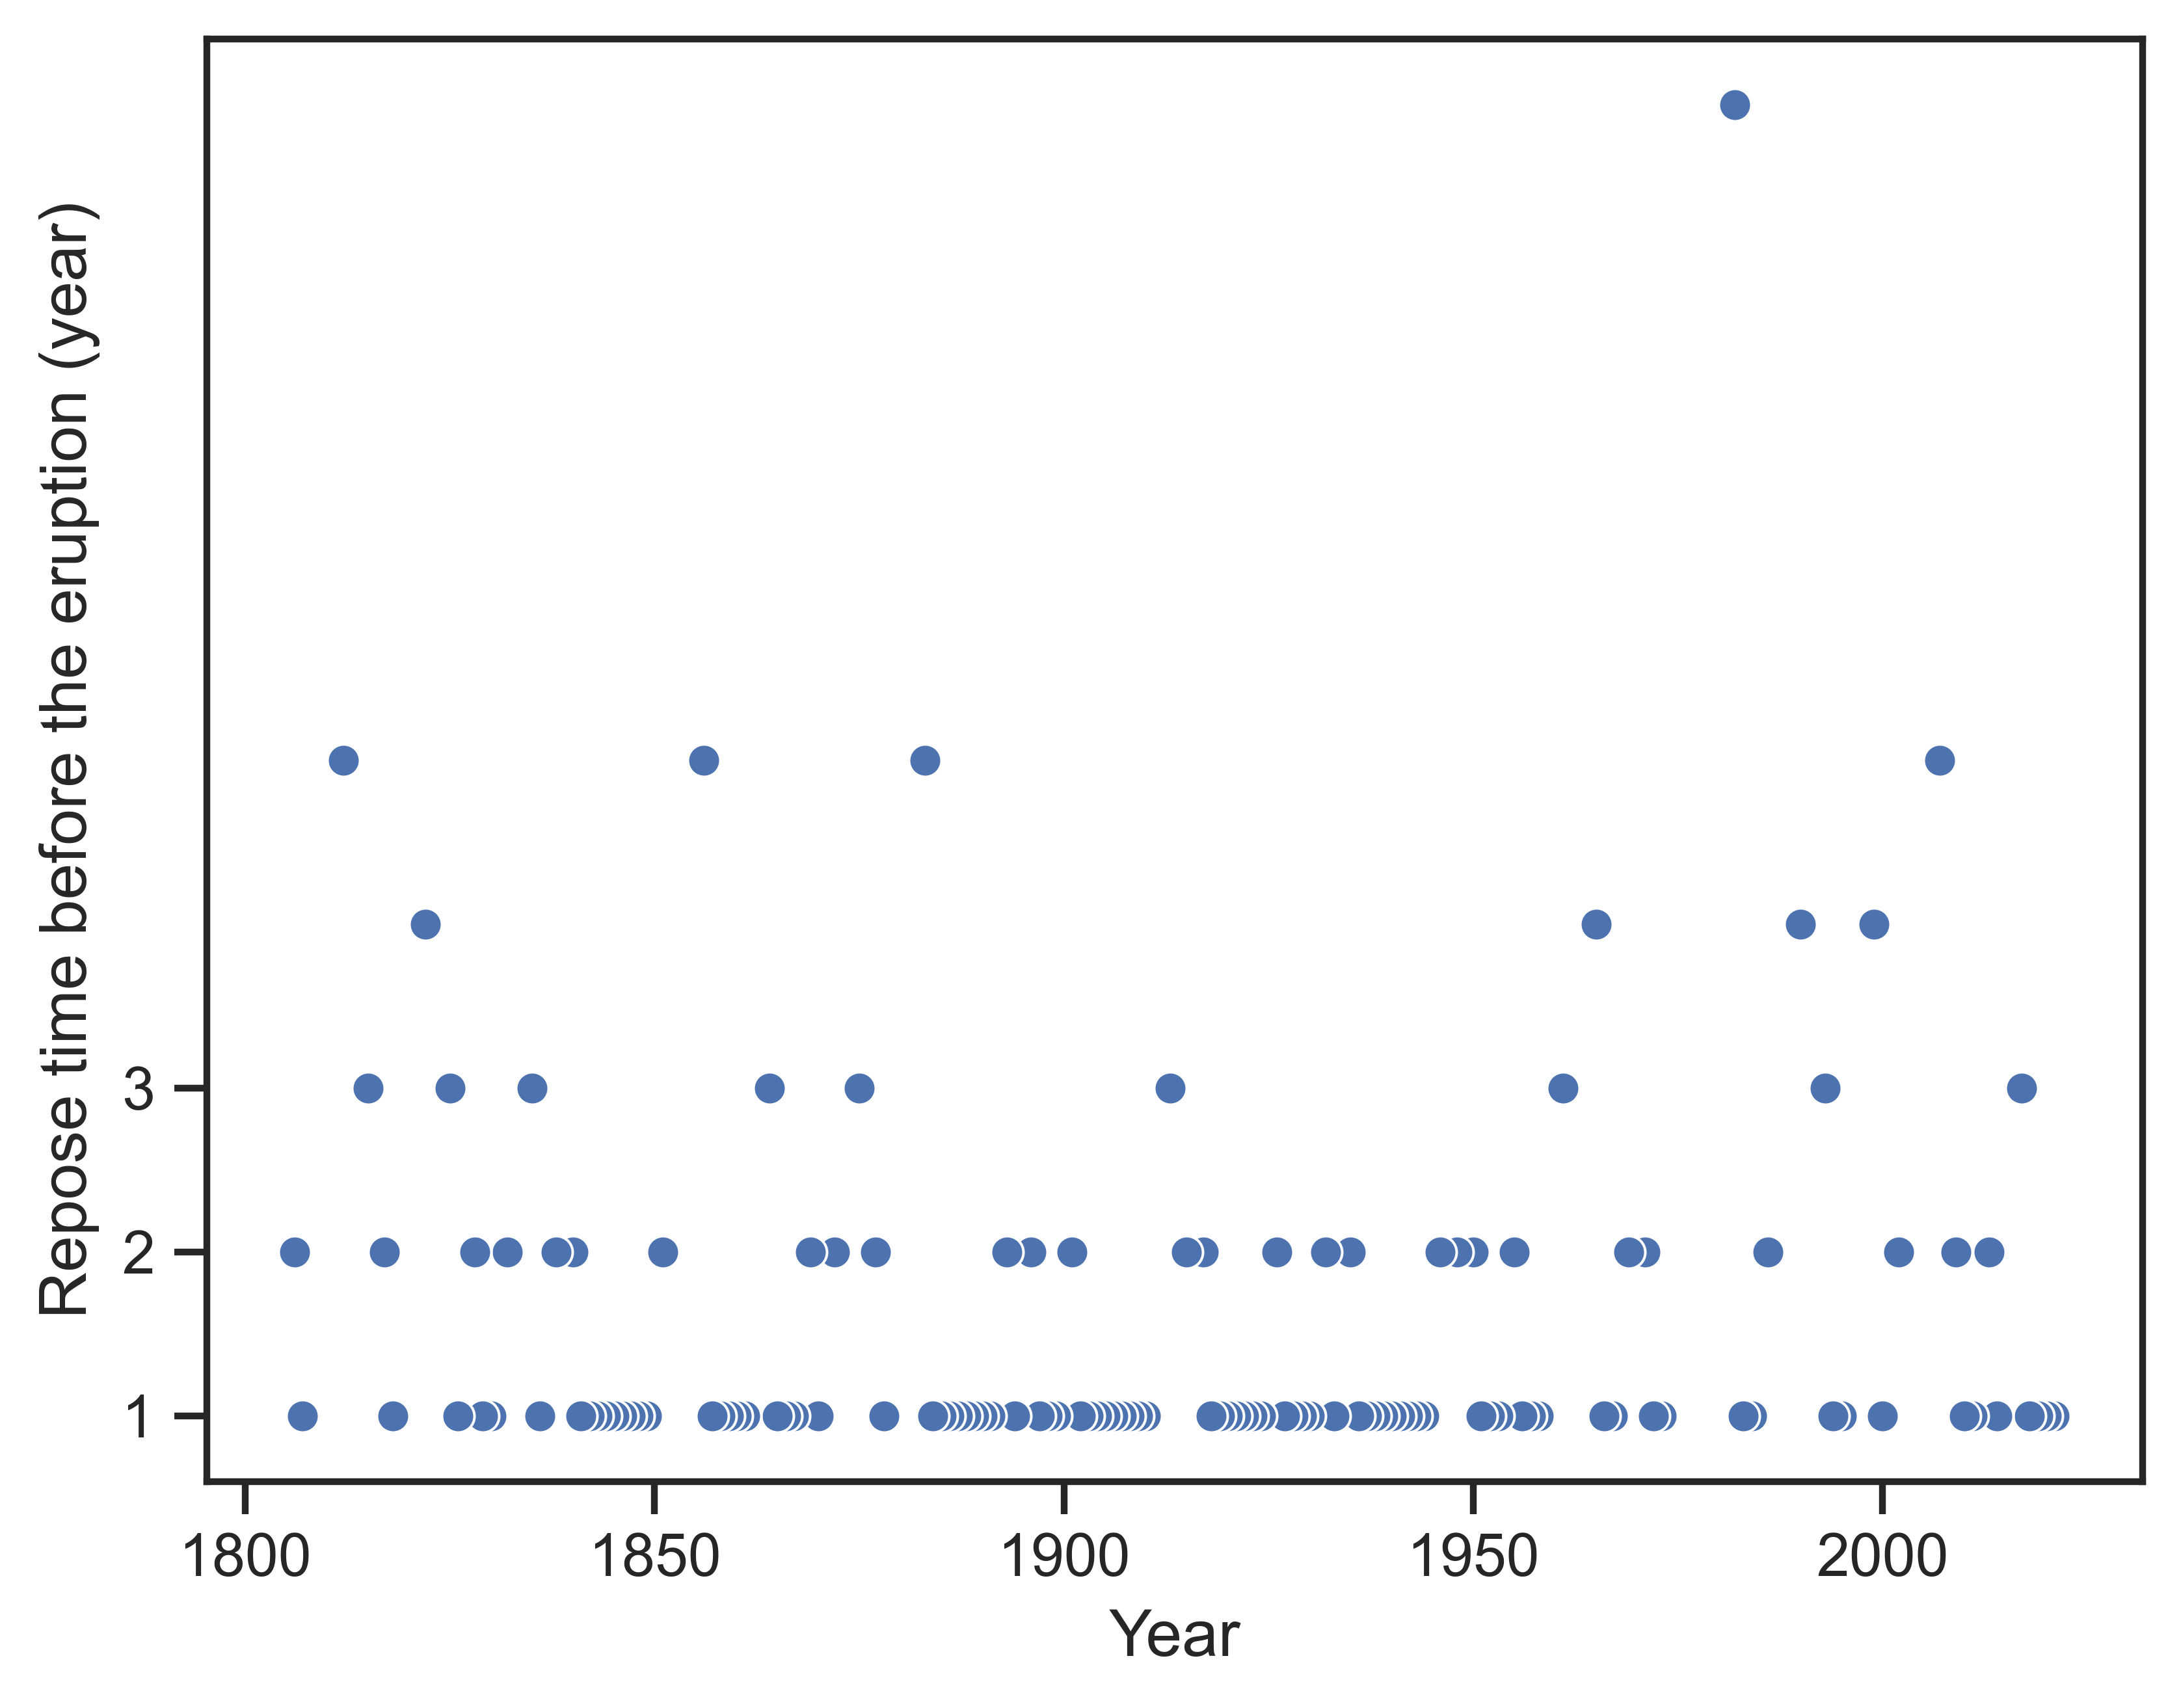

In [7]:
import seaborn as sns
sns.scatterplot(data=list2, x='Year', y='Repose')
plt.yticks(np.arange(1,4,1))
plt.ylabel('Repose time before the eruption (year)')

from statsmodels.tsa.stattools import adfuller, kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
result = adfuller(list2['Repose'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critical values:')
    print(f'   {key}, {value}')
if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

## independence check

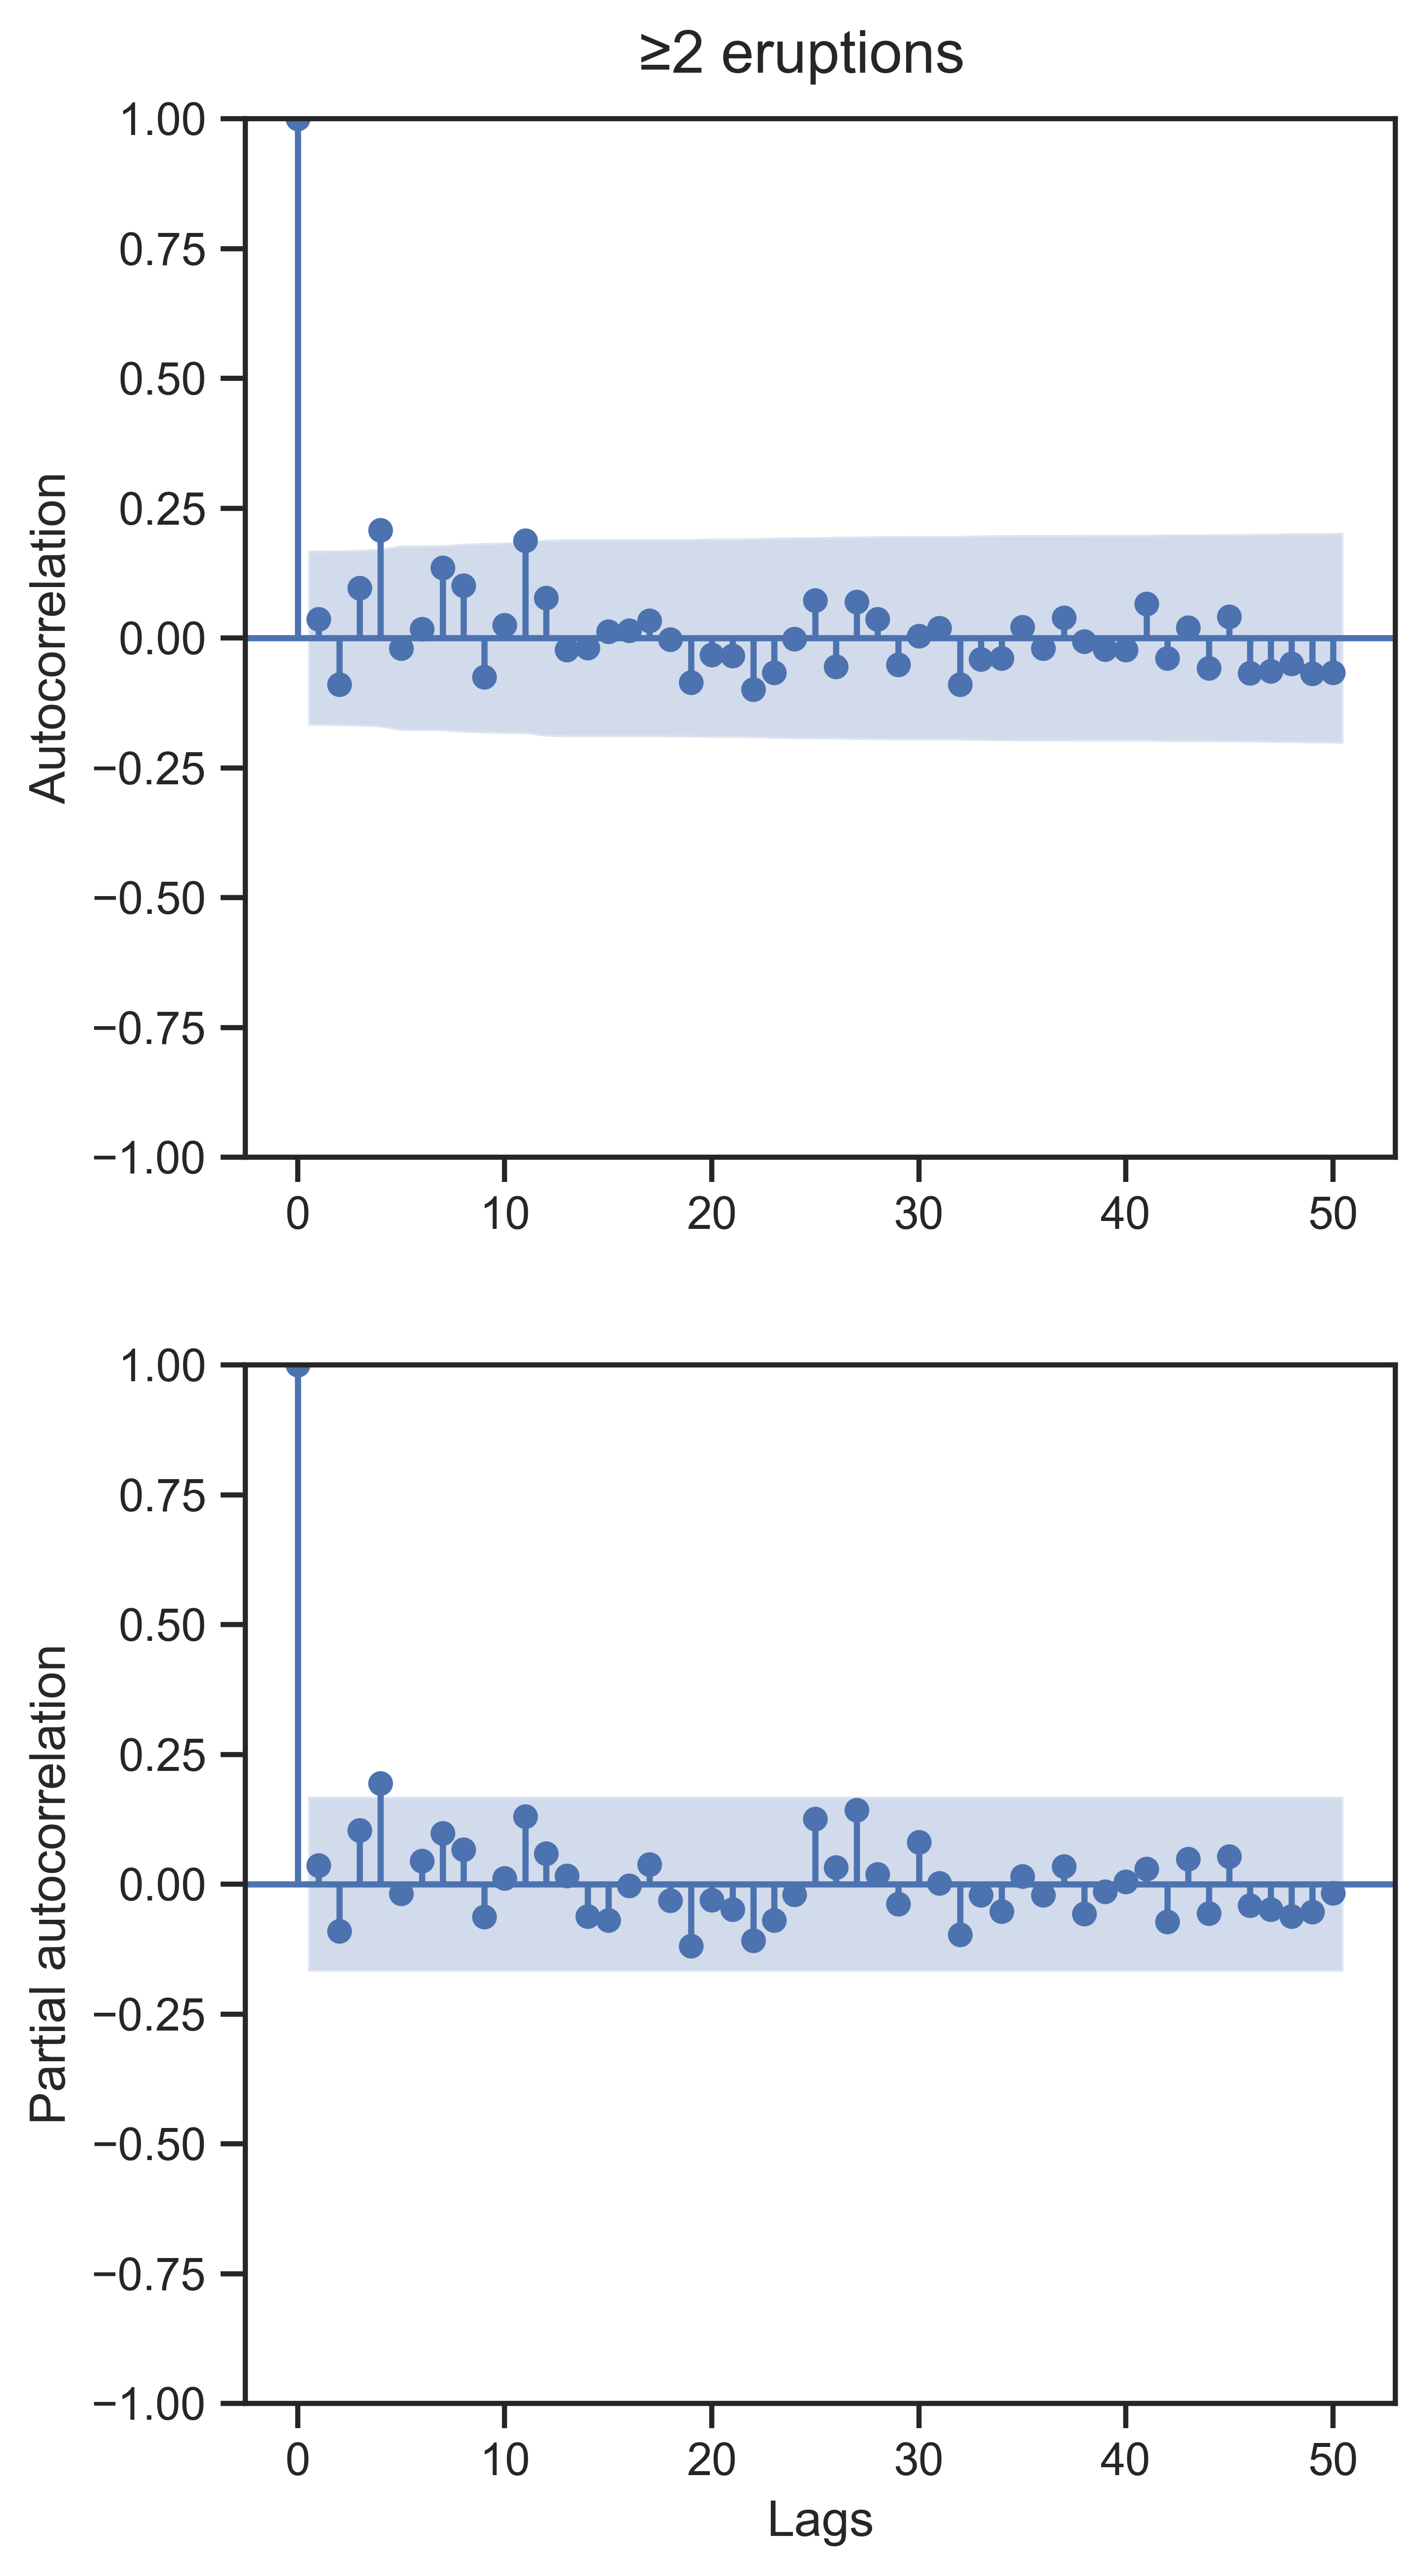

In [8]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 10))

# Check autocorrelation
plot_acf(x=list2['Repose'], lags=50, ax=axs[0])
fig.suptitle('≥2 eruptions',y=0.91)
axs[0].set_ylabel('Autocorrelation')
axs[0].set_title('')

# Check partial autocorrelation
plot_pacf(x=list2['Repose'], lags=50, ax=axs[1])
axs[1].set_ylabel('Partial autocorrelation')
axs[1].set_title('')
axs[1].set_xlabel('Lags')
plt.show()

## Descriptive statistic

In [9]:
print('modus :', list2['Repose'].mode())
print('median: ', list2['Repose'].median())
print('variansi: ', list2['Repose'].var())
print(list2['Repose'].describe())

modus : 0    1.0
Name: Repose, dtype: float64
median:  1.0
variansi:  1.3297954671088998
count    135.000000
mean       1.607407
std        1.153168
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        9.000000
Name: Repose, dtype: float64


## histogram repose time

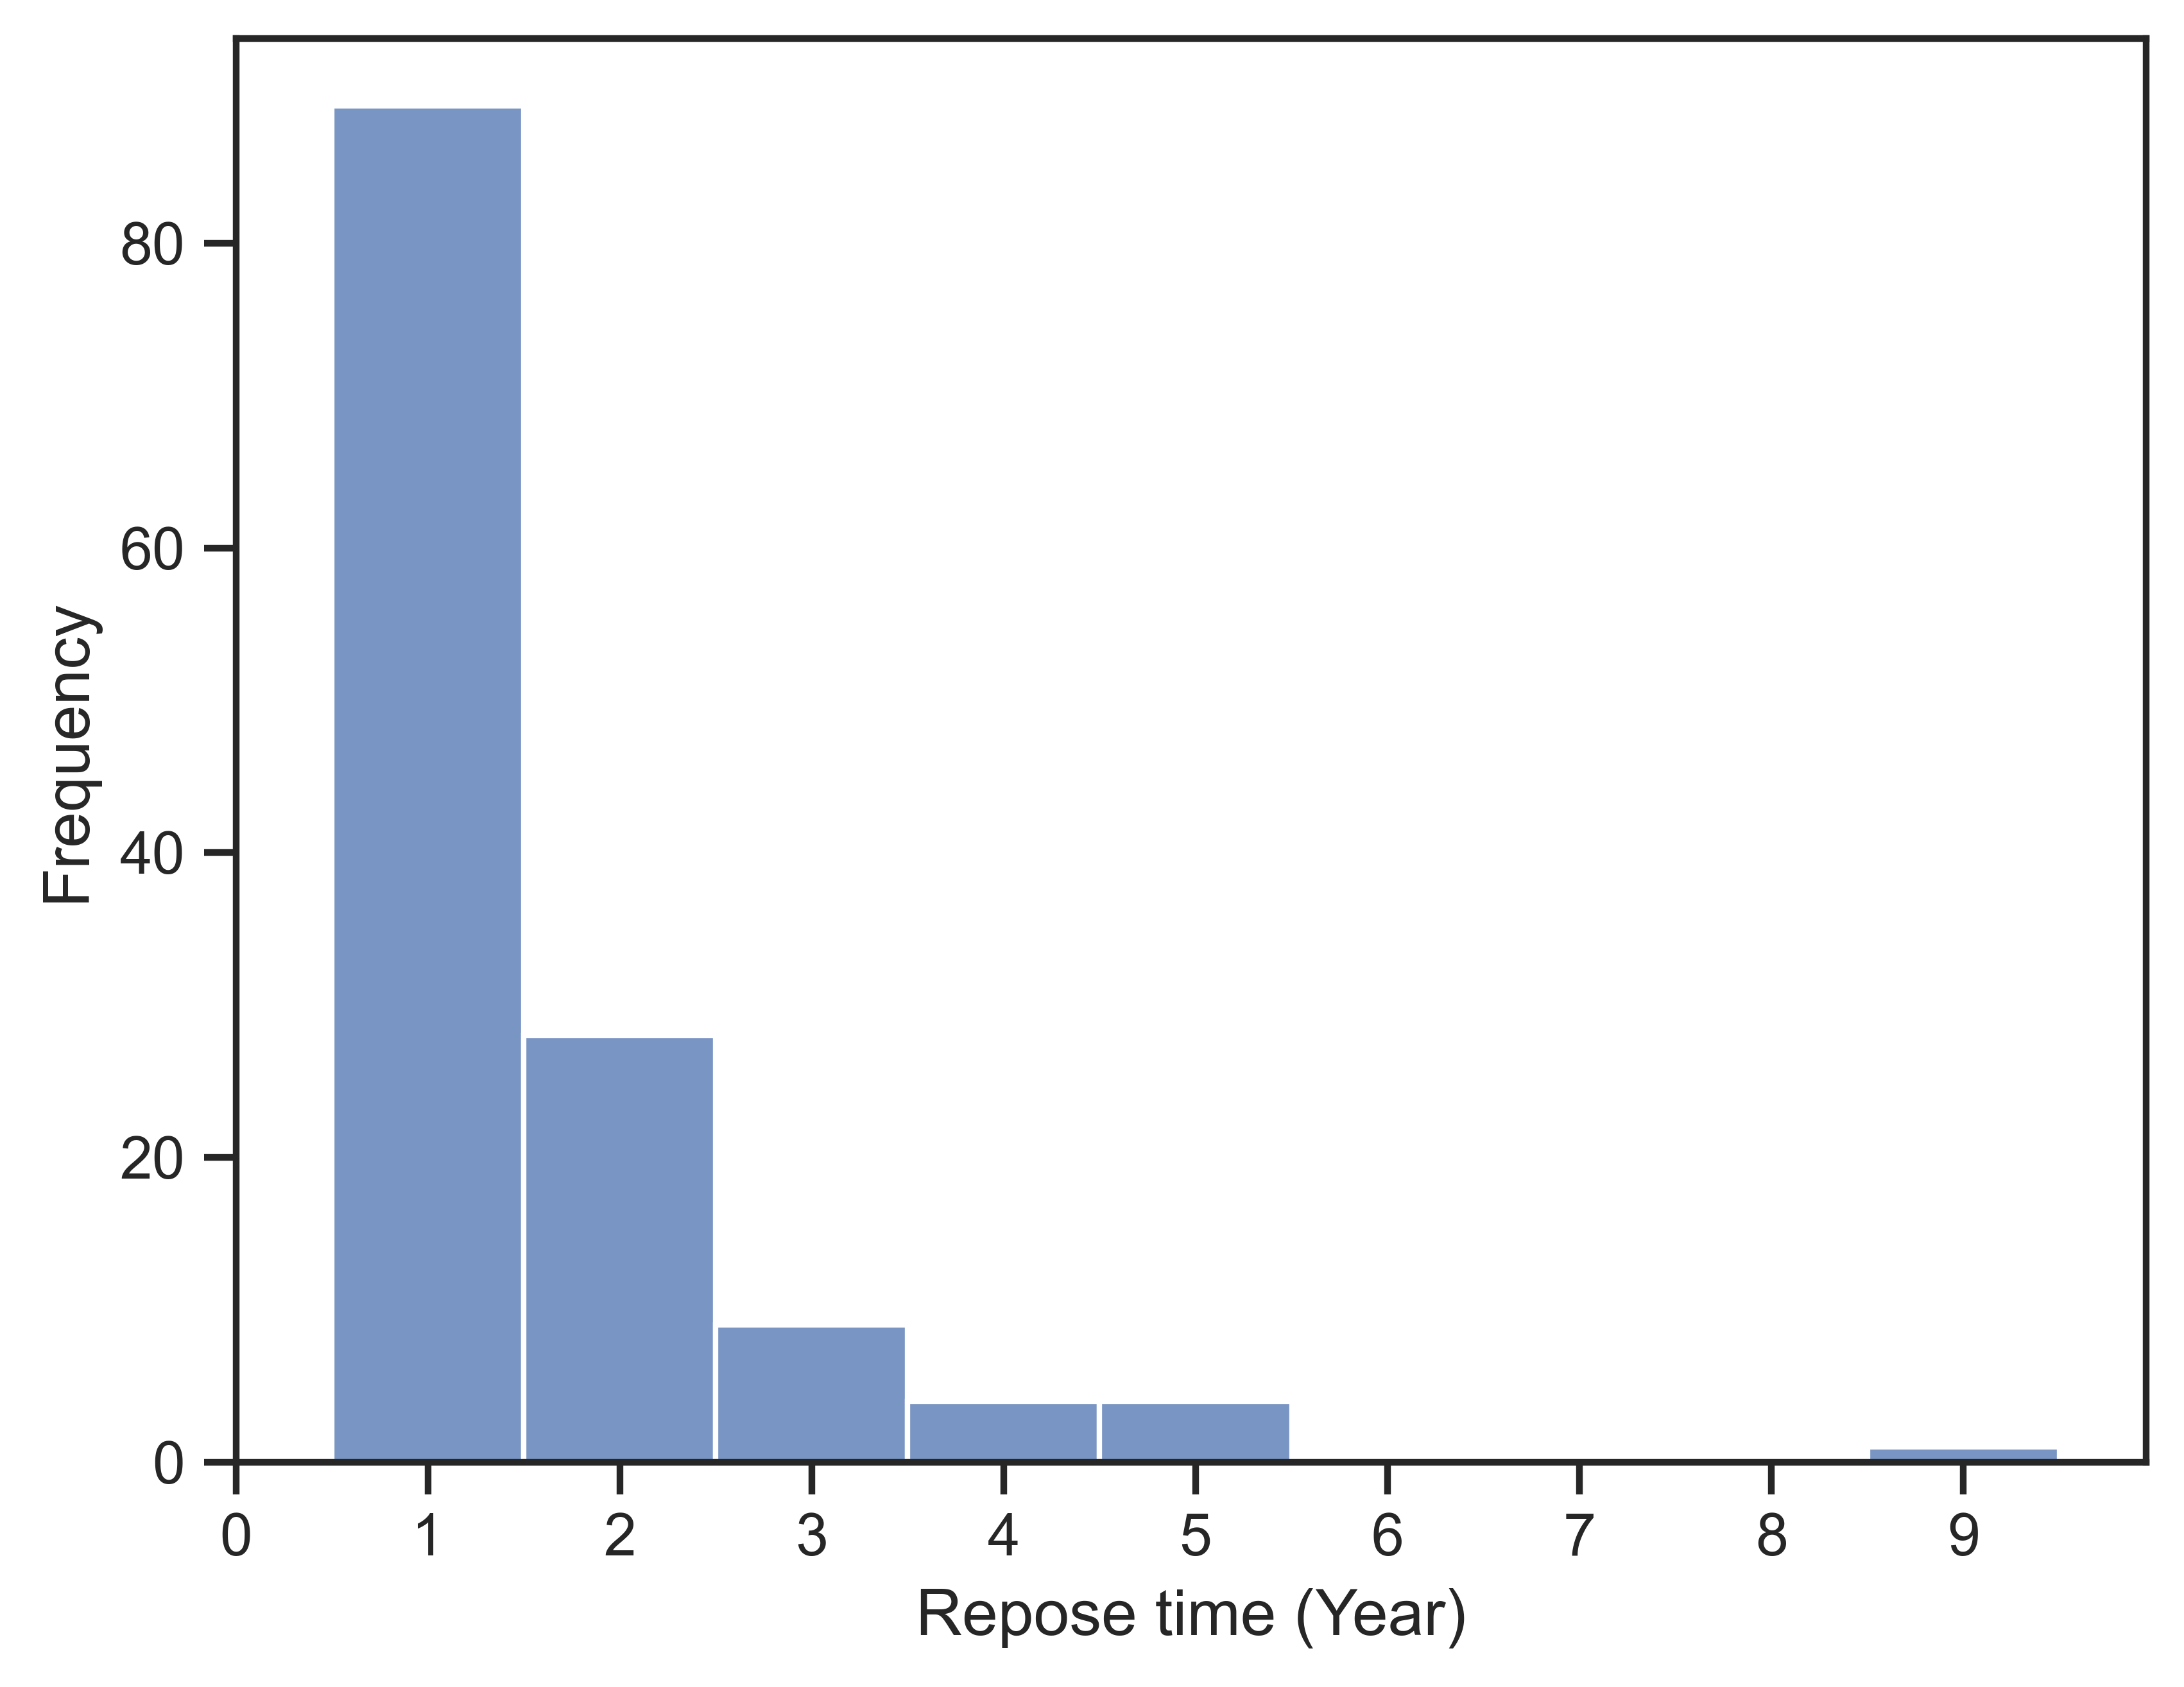

In [10]:
import seaborn as sns
sns.histplot(data=list2.Repose, discrete=True)
plt.ylabel('Frequency')
plt.xlabel('Repose time (Year)')
plt.xticks(np.arange(0,10,1))
plt.show()

## Test

C:\Users\geika\AppData\Local\Temp\ipykernel_21696\356596537.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list2.loc[list2.Repose >=0, 'Status'] = 1
C:\Users\geika\AppData\Local\Temp\ipykernel_21696\356596537.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list2['Repose'] = list2['Repose'].replace([0], 0.5)


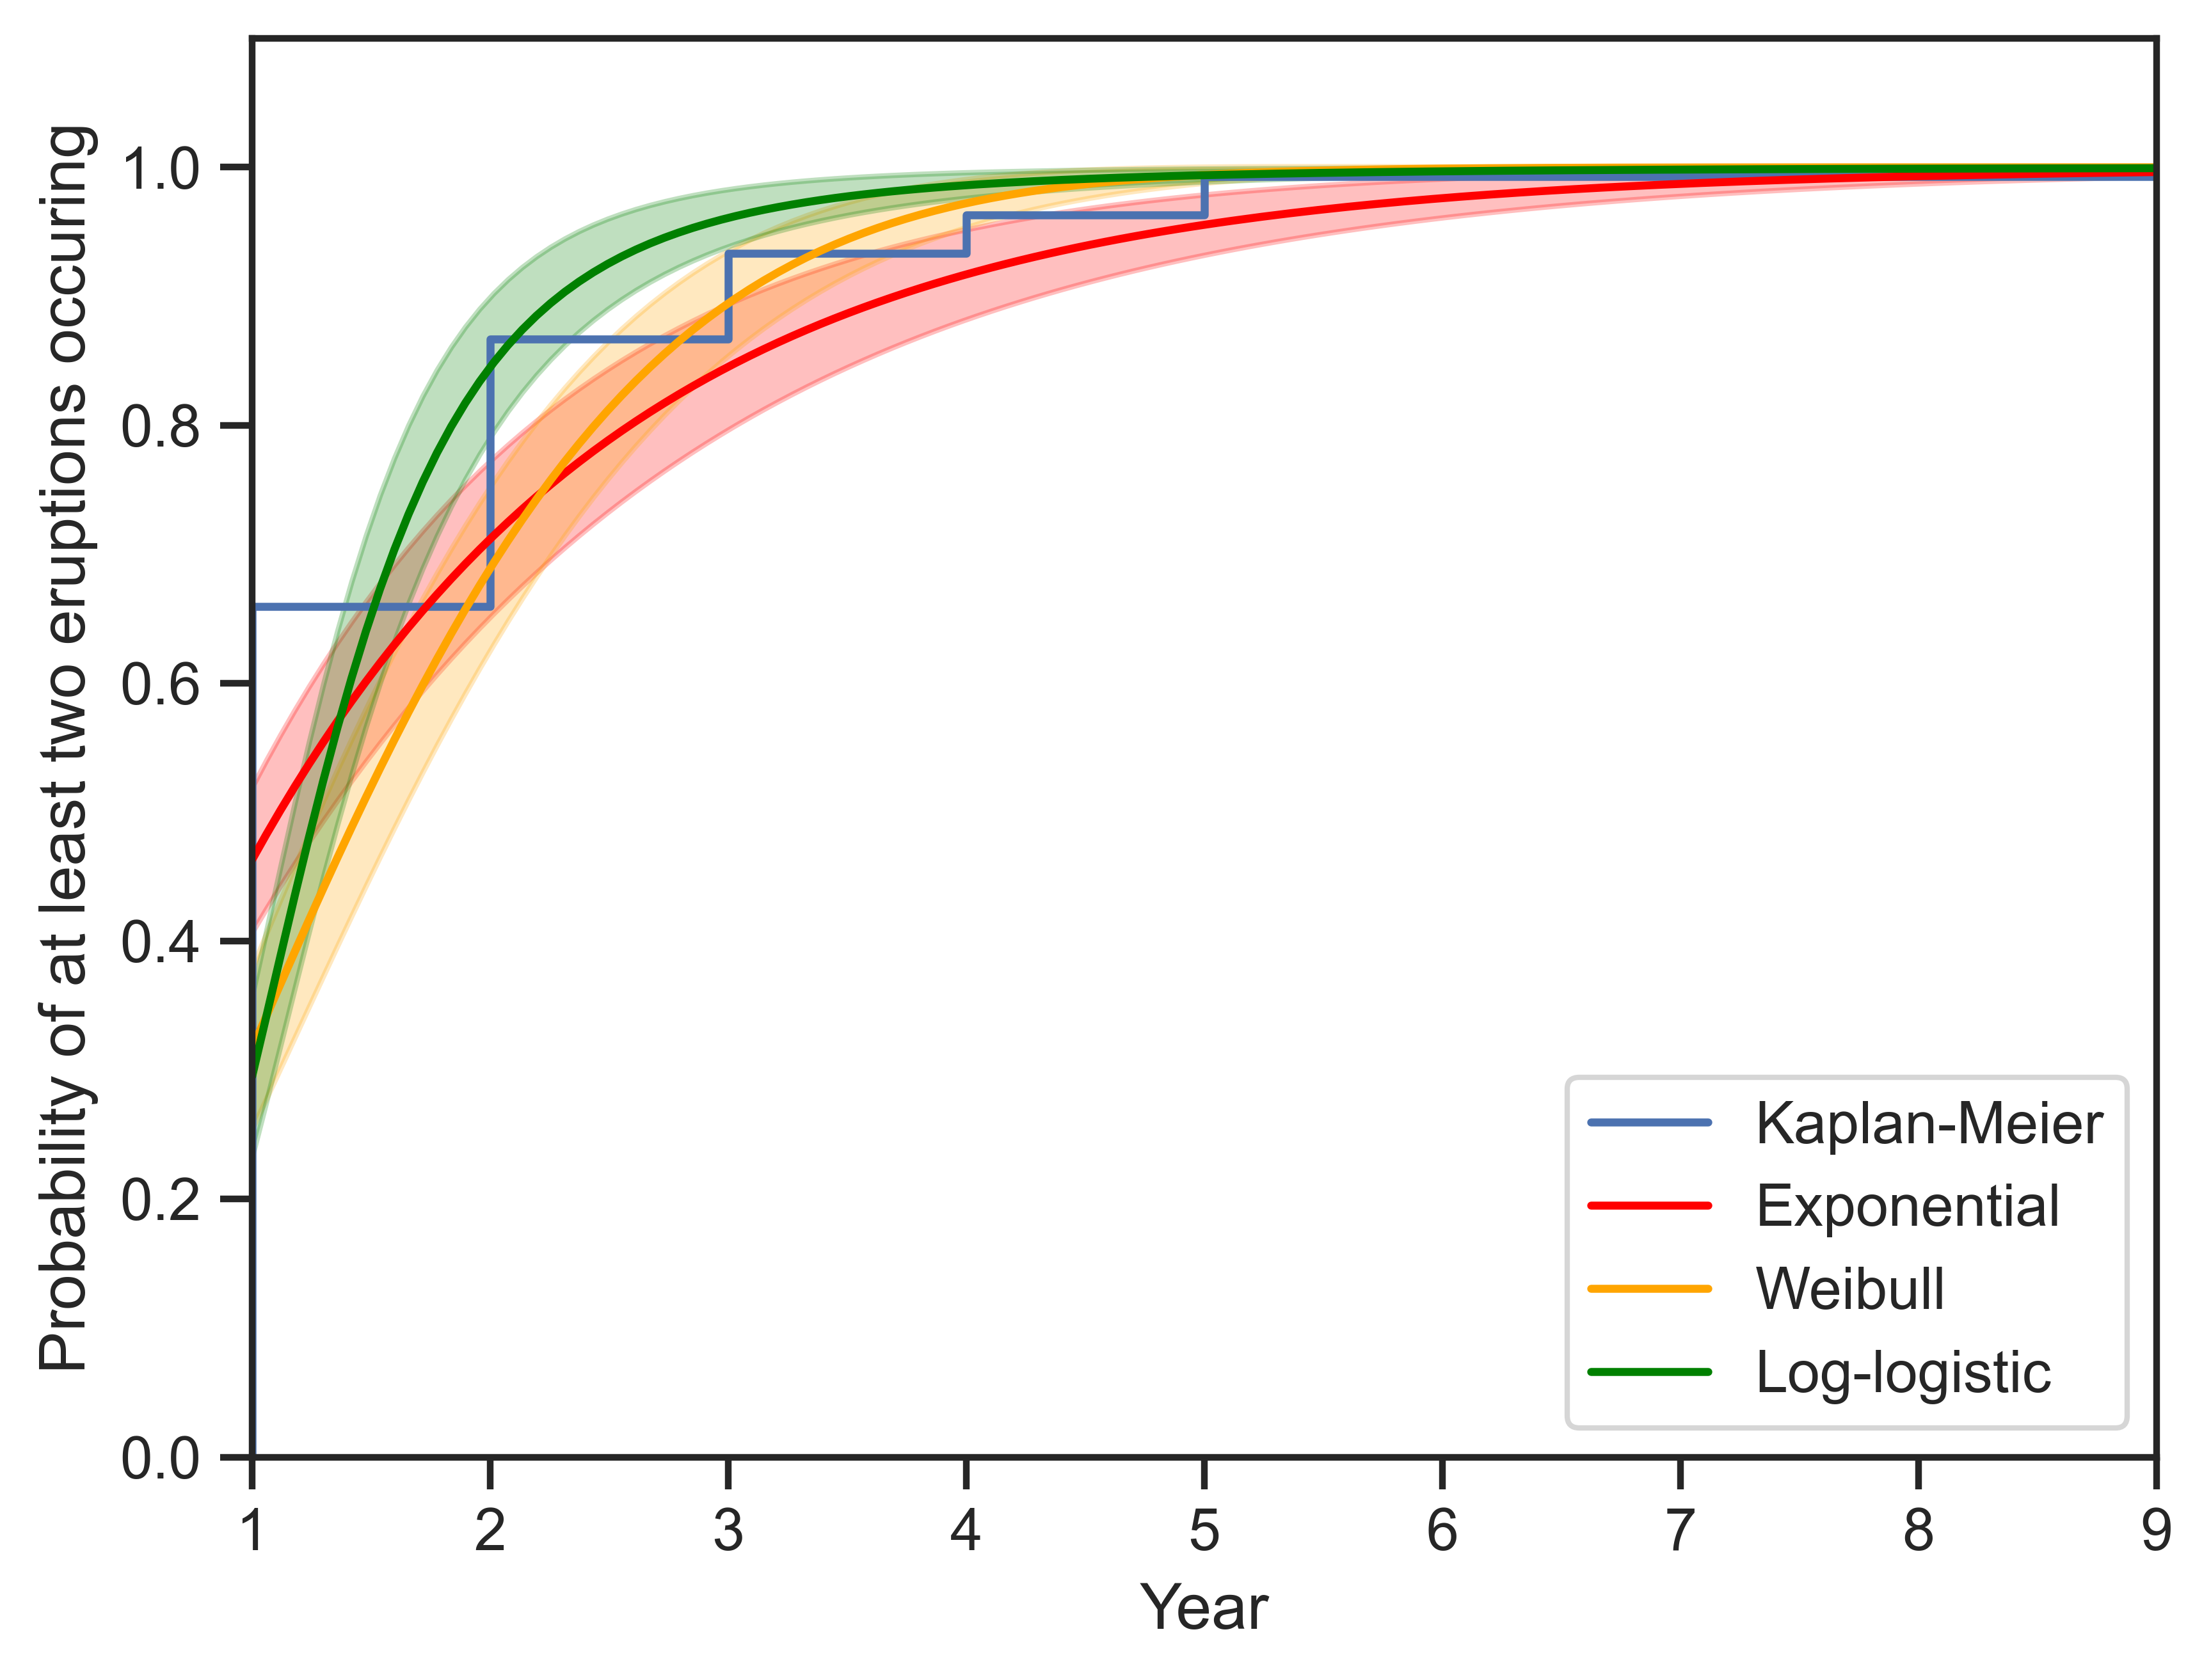

In [11]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
list2.loc[list2.Repose >=0, 'Status'] = 1
kmf.fit(durations=list2['Repose'], event_observed=list2['Status'], alpha=None)
list2['Repose'] = list2['Repose'].replace([0], 0.5)
kmf.plot_cumulative_density(ci_show=False, label='Kaplan-Meier')

#exponential
from lifelines import ExponentialFitter
exf = ExponentialFitter()
exf.fit(durations=list2['Repose'], event_observed=list2['Status'], alpha=None)
exf.plot_cumulative_density(ci_show=True, label='Exponential',color='red')

#weibull
from lifelines import WeibullFitter
wbf = WeibullFitter()
wbf.fit(durations=list2['Repose'], event_observed=list2['Status'], alpha=None)
wbf.plot_cumulative_density(ci_show=True, label='Weibull',color='orange')

#loglogistic
from lifelines import LogLogisticFitter
llf = LogLogisticFitter()
llf.fit(durations=list2['Repose'], event_observed=list2['Status'], alpha=None)
llf.plot_cumulative_density(ci_show=True, label='Log-logistic',color='green')
plt.ylabel('Probability of at least two eruptions occuring')
plt.xlabel('Year')
plt.xlim(1,9)
plt.ylim(0,1.1)
plt.yticks(np.arange(0,1.2,0.2))
plt.legend(loc=4)
plt.show()

## Evaluation

In [12]:
wbf.print_summary()
exf.print_summary()
llf.print_summary()

print(kmf.cumulative_density_at_times([0.5,1,2,3,4,5,10,15]))
print(wbf.cumulative_density_at_times([0.5,1,2,3,4,5,10,15]))
print(exf.cumulative_density_at_times([0.5,1,2,3,4,5,10,15]))
print(llf.cumulative_density_at_times([0.5,1,2,3,4,5,10,15]))

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 135 total observations, 0 right-censored observations>
   number of observations = 135
number of events observed = 135
           log-likelihood = -173.67
               hypothesis = lambda_ != 1, rho_ != 1

---
         coef  se(coef)  coef lower 95%  coef upper 95%
lambda_  1.82      0.10            1.61            2.02
rho_     1.62      0.09            1.44            1.80

         cmp to    z      p  -log2(p)
lambda_    1.00 7.92 <0.005     48.59
rho_       1.00 6.67 <0.005     35.19
---
AIC = 351.34

<lifelines.ExponentialFitter:"Exponential_estimate", fitted with 135 total observations, 0 right-censored observations>
   number of observations = 135
number of events observed = 135
           log-likelihood = -199.07
               hypothesis = lambda_ != 0

---
         coef  se(coef)  coef lower 95%  coef upper 95%
lambda_  1.61      0.14            1.34            1.88

         cmp to     z      p  -log2(p)
lambda_    0.00 11.62 <0.005    101.26
---
AIC = 400.15

<lifelines.LogLogisticFitter:"LogLogistic_estimate", fitted with 135 total observations, 0 right-censored observations>
   number of observations = 135
number of events observed = 135
           log-likelihood = -137.73
               hypothesis = alpha_ != 1, beta_ != 1

---
        coef  se(coef)  coef lower 95%  coef upper 95%
alpha_  1.26      0.05            1.16            1.37
beta_   3.70      0.27            3.17            4.23

        cmp to     z      p  -log2(p)
alpha_    1.00  5.13 <0.005     21.71
beta_     1.00 10.01 <0.005     75.97
---
AIC = 279.47

0.5     0.000000
1.0     0.659259
2.0     0.866667
3.0     0.933333
4.0     0.962963
5.0     0.992593
10.0    1.000000
15.0    1.000000
Name: KM_estimate, dtype: float64
0.5     0.116864
1.0     0.316816
2.0     0.689012
3.0     0.894525
4.0     0.972144
5.0     0.994117
10.0    1.000000
15.0    1.000000
Name: Weibull_estimate, dtype: float64
0.5     0.267330
1.0     0.463195
2.0     0.711840
3.0     0.845314
4.0     0.916964
5.0     0.955426
10.0    0.998013
15.0    0.999911
Name: Exponential_estimate, dtype: float64
0.5     0.031146
1.0     0.295178
2.0     0.845102
3.0     0.960771
4.0     0.986126
5.0     0.993881
10.0    0.999528
15.0    0.999895
Name: LogLogistic_estimate, dtype: float64
